Time of creation of phantom: 0.00 seconds
Time of generation of measured data: 0.25 seconds
start back projection
Time of back projection: 29.18 seconds


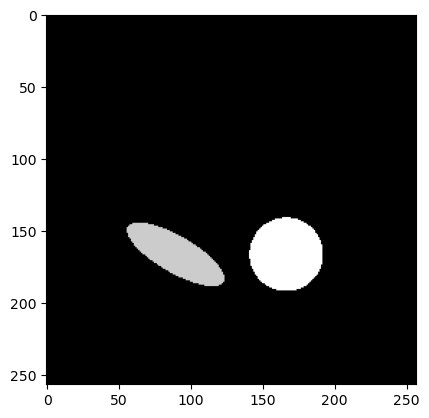

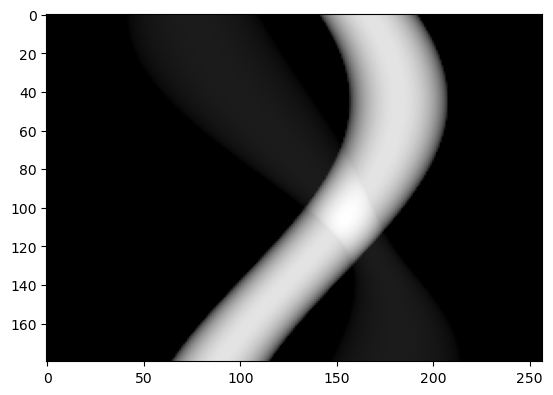

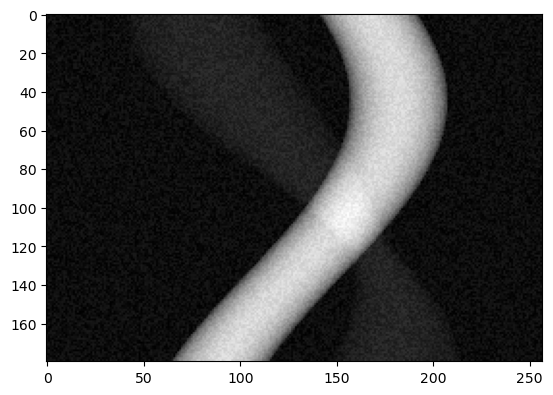

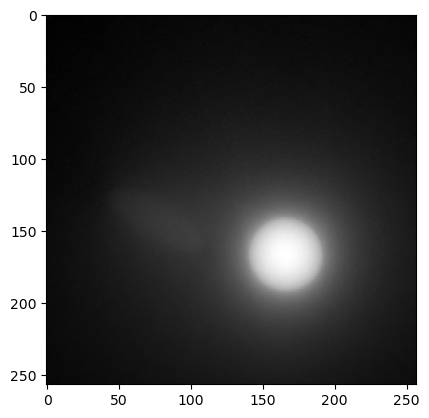

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift
import matplotlib.pyplot as plt
import time 

RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

def init_objects():
    # Initialize circle parameters
    # Each row: [radius, center_x, center_y, gray_value]
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    
    # Initialize ellipse parameters (optional)
    # Each row: [semi-major, semi-minor, center_x, center_y, angle, gray_value]
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.3, np.pi/6, 0.8]
    ])
    
    return circle_objects, ellipse_objects

def create_phantom(circle_objects=None, ellipse_objects = None, res = 5):
    time_start = time.time()
    # Create a phantom image based on given objects
    phantom = np.zeros((2*res+1, 2*res+1))

    if circle_objects is not None:
        for params in circle_objects:
            phantom += phantom_circle(params, res)
    if ellipse_objects is not None:
        for params in ellipse_objects:
            phantom += phantom_ellipse(params, res)

    if np.sum(phantom)<1:
        print('Warning: object lists are empty.')
    print(f"Time of creation of phantom: {time.time()-time_start:.2f} seconds")
    return phantom

def phantom_circle(parameters, res):
    radius, center_x, center_y, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(parameters, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2 + ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2 <= 1
    return gray_value * mask

def generate_measured_data(p, q, circle_objects=None, ellipse_objects=None):
    start_time = time.time()
    if circle_objects is not None and ellipse_objects is not None:
        delta_phi = np.pi / p
        phi = np.arange(p) * delta_phi
        s = np.linspace(-1, 1, 2*q+1)
        
        sinogram = np.zeros((p, 2*q+1))

        for i in range(p):
            omega = np.array([np.cos(phi[i]), np.sin(phi[i])]) #create omega vector
            for j in range(-q, q+1):
                sinogram[i, j+q] += calculate_radon_transform_circle(circle_objects, s[j+q], omega)
                sinogram[i, j+q] += calculate_radon_transform_ellipse(ellipse_objects, s[j+q], phi[i])
    else:
        print('Warning: object lists are empty.')
        sinogram = None
        phi = None
        s = None
    print(f"Time of generation of measured data: {time.time()-start_time:.2f} seconds")
    return sinogram, phi, s
def generate_measured_data_integration(p, q, phantom, res):
    """
    Generate measured data (sinogram) for given phantom using trapezoidal rule.

    Parameters:
    p (int): Number of projection angles.
    q (int): Number of detectors per projection.
    phantom (np.array): Phantom image.
    res (int): Resolution of the phantom.

    Returns:
    np.array: Generated sinogram.
    np.array: Projection angles (phi).
    np.array: Detector positions (s).
    """
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    # delta_s = 2 / (2*q)
    s = np.linspace(-1, 1, 2*q+1)
    
    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = trapezoidal_integration(phantom, s[j+q], omega, res)
    
    return sinogram, phi, s

def trapezoidal_integration(phantom, s, omega, res:int):
    """
    Perform trapezoidal integration to compute the Radon transform.

    Parameters:
    phantom (np.array): Phantom image.
    s (float): Detector position.
    omega (np.array): Projection direction.
    res (int): Resolution of the phantom.

    Returns:
    float: Integrated value.
    """
    step_size = 1 / ( res)
    integral_sum = 0.0
    row_min, col_min = res, res
    row_max, col_max = 0, 0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = EvaluateMatrix(point, res)

        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            # if row < row_min:  row_min = row
            # if row > row_max:  row_max = row
            # if col < col_min:  col_min = col 
            # if col > col_max:  col_max = col
            integral_sum += phantom[row, col]
    
    # integral_value = step_size * (integral_sum - 0.5 * (phantom[row_min, col_min] + phantom[row_max, col_max]))
    integral_value = step_size * (integral_sum - 0.5 * (phantom[0, 0] + phantom[-1, -1]))
    return integral_value

def EvaluateMatrix(point, res):
    """
    Evaluate the phantom at a given point (x, y).

    Parameters:
    point (tuple): Coordinates (x, y) of the point to evaluate.
    res (int): Resolution of the phantom.
    phantom (np.array): Phantom image.

    Returns:
    int: Matrix row index corresponding to the point.
    int: Matrix column index corresponding to the point.
    """
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col

def calculate_radon_transform_circle(circle_data, s, omega):
    radon_value = 0
    for circle in circle_data:
        radius, center_x, center_y, gray_value = circle
        term = radius**2 - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = gray_value * np.sqrt(term) * 2 
            radon_value += projection
    return radon_value

def calculate_radon_transform_ellipse(ellipse_data, s, phi):
    radon_value = 0
    for ellipse in ellipse_data:
        semi_major, semi_minor, center_x, center_y, angle, gray_value = ellipse
        omega = np.array([np.cos(phi- angle), np.sin(phi- angle)])
        denom_square = (semi_major * omega[0]) **2 + (semi_minor * omega[1]) **2
        term = denom_square - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = 2* gray_value  * semi_major * semi_minor * np.sqrt(term) / np.sqrt(denom_square)
            radon_value += projection

    return radon_value

def add_noise(sinogram, noise_level):
    noise = np.random.rand(*sinogram.shape) * noise_level
    sinogram_noisy = sinogram + noise
    return sinogram_noisy

def filtered_back_projection(sinogram, p, q, filter_choice, res):

    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)

    # Calculate the filte4r
    b = 0.96
    filter = calculate_filter(s, b, filter_choice)

    start_time = time.time()
    if filter_choice is not None:
        print("start filtering")
        filtered_sinogram = np.zeros_like(sinogram)
        for i in range(p):
            filtered_sinogram[i, :] = calculate_convolution(sinogram[i, :], p, q, filter)
        print(f"Time of convolution: {time.time()-start_time:.2f} seconds")
        plot(filtered_sinogram)
    else:
        filtered_sinogram = sinogram
    # Back projection
    print("start back projection")
    start_time = time.time()
    fFBI = np.zeros((2*res+1, 2*res+1))
    for x in range(-res, res+1):
        for y in range(-res, res+1):
            for i in range(p):
                # omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
                omega = np.array([np.sin(phi[i]), np.cos(phi[i])])
                s_xy = x * omega[0] + y * omega[1]
                if s_xy > res-1:
                    fFBI[x+res, y+res] += filtered_sinogram[i, 2*q]
                else:
                    u = s_xy - int(s_xy)
                    fFBI[x+res, y+res] += (1-u)*filtered_sinogram[i, int(s_xy+q)] + u*filtered_sinogram[i, int(s_xy+q)+1]

    print(f"Time of back projection: {time.time()-start_time:.2f} seconds")
    return fFBI*np.pi/p

def gaussian_filter(phantom, sigma, size,res):
    kernel = np.exp(-np.arange(-size, size+1)**2 / (2*sigma**2))
    kernel = kernel / np.sum(kernel)
    # fGaussian = np.zeros_like(phantom)
    # for x in range():


def calculate_filter(s,b = 0.5, filterchoice = RAMLAK):
    """
    s: vector
    b: cut-off frequency
    """
    # print(filterchoice)
    if filterchoice is RAMLAK:
        filter = np.abs(s)
        # print(filter)
        filter[abs(filter) > b] = 0
        # print(filter)
    elif filterchoice is SHEPPLOGAN:
        filter = np.abs(s) * np.sinc(s)
        filter[s > b] = 0
    elif filterchoice is COSINE:
        filter = np.abs(s) * np.cos(np.pi * s / (2 * b))
        filter[s > b] = 0
    else:
        filter = np.ones_like(s)

    return filter

def calculate_convolution(sinogram, p,q, filter):
    sinogram_fft = fft(sinogram)
    sinogram_filtered = np.real(ifft(sinogram_fft * filter))

    return sinogram_filtered

def plot(sinogram):
    fig, ax = plt.subplots()
    ax.imshow(sinogram, cmap='gray')

res =128
p = 180
q = 128
noiselevel = 0.05
# Initialize objects
circle_objects, ellipse_objects = init_objects()

# Create phantom
phantom = create_phantom(circle_objects, ellipse_objects, res)  # Assuming resolution 128

fig, ax = plt.subplots()
ax.imshow(phantom, cmap='gray')

# Generate measured data
sinogram, phi, s = generate_measured_data(p, q, circle_objects, ellipse_objects)  # Example values for p and q

fig, ax = plt.subplots()
ax.imshow(sinogram, cmap='gray')

sinogram_noisy = add_noise(sinogram, noiselevel)  # Example noise level
fig, ax = plt.subplots()
ax.imshow(sinogram_noisy, cmap='gray')

# Filtered back projection
filter_choice = None  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(sinogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')